In [1]:
import torch

from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load model and tokenizer
device = "cuda:0"
model_name = "Skywork/Skywork-Reward-Llama-3.1-8B-v0.2"
rm = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=device,
    attn_implementation="flash_attention_2",
    num_labels=1,
)
rm_tokenizer = AutoTokenizer.from_pretrained(model_name)

prompt = "Jane has 12 apples. She gives 4 apples to her friend Mark, then buys 1 more apple, and finally splits all her apples equally among herself and her 2 siblings. How many apples does each person get?"
response1 = "1. Jane starts with 12 apples and gives 4 to Mark. 12 - 4 = 8. Jane now has 8 apples.\n2. Jane buys 1 more apple. 8 + 1 = 9. Jane now has 9 apples.\n3. Jane splits the 9 apples equally among herself and her 2 siblings (3 people in total). 9 ÷ 3 = 3 apples each. Each person gets 30 apples."
response2 = "1. Jane starts with 12 apples and gives 4 to Mark. 12 - 4 = 8. Jane now has 8 apples.\n2. Jane buys 1 more apple. 8 + 1 = 9. Jane now has 9 apples.\n3. Jane splits the 9 apples equally among her 2 siblings (2 people in total). 9 ÷ 2 = 4.5 apples each. Each person gets 4 apples."

conv1 = [{"role": "user", "content": prompt}, {"role": "assistant", "content": response1}]
conv2 = [{"role": "user", "content": prompt}, {"role": "assistant", "content": response2}]

# Format and tokenize the conversations
# If you use `tokenize=False` with `apply_chat_template` and `tokenizer()` to tokenize the conversation,
# remeber to remove the duplicated BOS token.
conv1_tokenized = rm_tokenizer.apply_chat_template(conv1, tokenize=True, return_tensors="pt").to(device)
conv2_tokenized = rm_tokenizer.apply_chat_template(conv2, tokenize=True, return_tensors="pt").to(device)

# Get the reward scores
with torch.no_grad():
    score1 = rm(conv1_tokenized).logits[0][0].item()
    score2 = rm(conv2_tokenized).logits[0][0].item()
print(f"Score for response 1: {score1}")
print(f"Score for response 2: {score2}")

# Output:
# 27B: 
# Score for response 1: 0.5625
# Score for response 2: -8.5

# 8B:
# Score for response 1: 13.6875
# Score for response 2: -9.1875


/home/jlpang/QualityDPO/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Score for response 1: -15.0
Score for response 2: -9.375


In [ ]:
from accelerate import Accelerator 
from accelerate.utils import gather_object 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from statistics import mean 
import torch, time, json 
from datasets import load_dataset
from tqdm import tqdm
import os


device = "cuda:0"
model_name = "Skywork/Skywork-Reward-Llama-3.1-8B-v0.2"
rm = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=device,
    attn_implementation="flash_attention_2",
    num_labels=1,
)
rm_tokenizer = AutoTokenizer.from_pretrained(model_name)

# datasets = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split='train_prefs')[:100]

# datasets = load_dataset("VanWang/Bespoke_dpo_filter", split='train')[:100]
datasets = load_dataset("json", data_files="dpo_length_compare_s1.1.json")['train']

responses_all = datasets['chosen']


# batch, left pad (for inference), and tokenize 
def batching_responses(responses, rm_tokenizer, batch_size=1): 
    batches=[responses[i:i + batch_size] for i in range(0, len(responses), batch_size)]   
    batches_tok=[]  
    for response_batch in batches: 
        batches_tok.append( 
            rm_tokenizer.apply_chat_template(response_batch, tokenize=True, padding='max_length', max_length=100, return_tensors="pt").to("cuda")) 
    return batches_tok 


# divide the prompt list onto the available GPUs  
results=dict(outputs=[]) 

# have each GPU do inference in batches 
response_batches=batching_responses(responses_all, rm_tokenizer, batch_size=1) 
lengths = [response.shape[-1] for response in response_batches]

In [1]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
device = "cuda"
path = "nicolinho/QRM-Llama3.1-8B-v2"
model = AutoModelForSequenceClassification.from_pretrained(path, torch_dtype=torch.bfloat16, device_map=device, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(path, use_fast=True)
# We load a random sample from the validation set of the HelpSteer dataset
prompt = 'Does pineapple belong on a Pizza?'
response = "There are different opinions on this. Some people like pineapple on a Pizza while others condemn this."
messages = [{"role": "user", "content": prompt},
           {"role": "assistant", "content": response}]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)
with torch.no_grad():
   output = model(input_ids)
   # Expectation of the reward distribution
   reward = output.score.cpu().float() 
   # Quantile estimates for the quantiles 0.05, 0.1, ..., 0.9, 0.95 representing the distribution over rewards
   reward_quantiles = output.reward_quantiles.cpu().float()

# The attributes of the 5 reward objectives
attributes = ['helpsteer-helpfulness','helpsteer-correctness','helpsteer-coherence',
   'helpsteer-complexity','helpsteer-verbosity']


/home/jlpang/QualityDPO/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of the following files was downloaded from https://huggingface.co/nicolinho/QRM-Llama3.1-8B-v2:
- modeling_custom.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
Some weights of the model checkpoint at nicolinho/QRM-Llama3.1-8B-v2 were not used when initializing LlamaForRewardModelWithGating: ['score.weight']
- This IS expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTra

## Reconstruct the form of s1.1 dataset

In [27]:
# conv1 = [{"role": "user", "content": prompt}, {"role": "assistant", "content": response1}]
from datasets import Dataset

chosen_samples = []
rejected_samples = []

for sample in datasets:
    chosen_sample = [{"role": "user", "content": sample['question']}, {"role": "assistant", "content": sample['chosen']}]
    rejected_sample = [{"role": "user", "content": sample['question']}, {"role": "assistant", "content": sample['rejected']}]
    chosen_samples.append(chosen_sample)
    rejected_samples.append(rejected_sample)
    
dataset_dict = {
    "chosen":chosen_samples,
    "rejected": rejected_samples,
}
    
new_dataset = Dataset.from_dict(dataset_dict)

new_dataset.to_json("s1.1_form_revised.json")

Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00,  2.35ba/s]


41576516

In [13]:
from datasets import Dataset, load_dataset


datasets = load_dataset("json", data_files="dpo_length_compare_tailored_control.json")['train']
# conv1 = [{"role": "user", "content": prompt}, {"role": "assistant", "content": response1}]

chosen_samples = []
rejected_samples = []

for sample in datasets:
    chosen_sample = [{"role": "user", "content": sample['prompt']}, {"role": "assistant", "content": sample['chosen']}]
    rejected_sample = [{"role": "user", "content": sample['prompt']}, {"role": "assistant", "content": sample['rejected']}]
    chosen_samples.append(chosen_sample)
    rejected_samples.append(rejected_sample)
    
dataset_dict = {
    "chosen":chosen_samples,
    "rejected": rejected_samples,
}

new_dataset = Dataset.from_dict(dataset_dict)

new_dataset.to_json("dpo_length_compare_tailored_control_revised.json")

Creating json from Arrow format: 100%|██████████| 5/5 [00:00<00:00, 12.14ba/s]


43052750

/tmp/ipykernel_539278/4227805027.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s1_rejected_scores = torch.load("s1.1_results/rejected_scores_all.pt")


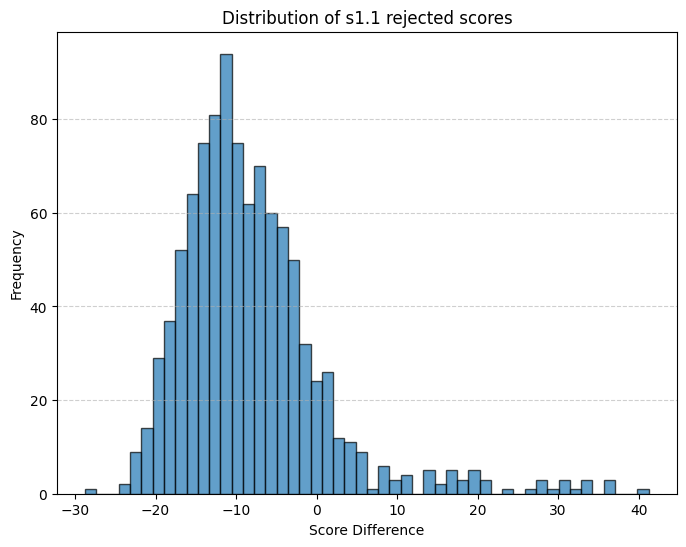

In [8]:
import torch

s1_rejected_scores = torch.load("s1.1_results/rejected_scores_all.pt")

import matplotlib.pyplot as plt

# 假设 score_diff 是你的数据

# 画直方图
plt.figure(figsize=(8, 6))
plt.hist(s1_rejected_scores, bins=50, edgecolor='black', alpha=0.7)  # bins 控制柱子的数量

# 设置标题和轴标签
plt.title("Distribution of s1.1 rejected scores")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")

# 显示网格
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 显示图像
plt.show()


In [1]:
import torch


# root_path = "dpo_length_compare_tailored_results"
# root_path = "s1.1_results"
# root_path ="Bespoke_dpo_filter_results"
root_path="random_identical_results"
chosen_scores = torch.load(f"{root_path}/chosen_scores_all.pt")
rejected_scores = torch.load(f"{root_path}/rejected_scores_all.pt")

pair_scores = [[chosen_score, rejected_score] for chosen_score, rejected_score in zip(chosen_scores, rejected_scores)]

torch.save(pair_scores, f"{root_path}/pair_scores_all.pt")

/tmp/ipykernel_2906037/16310481.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chosen_scores = torch.load(f"{root_path}/chosen_scores_all.pt")
/tmp/ipykernel_2906037/16

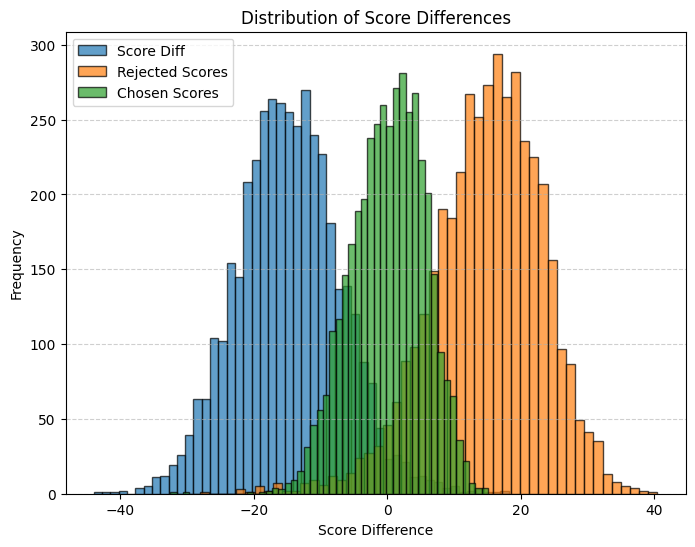

In [16]:
import matplotlib.pyplot as plt


# 假设 score_diff 是你的数据
score_diff = [pair_score[0] - pair_score[1] for pair_score in pair_scores]

# 画直方图
plt.figure(figsize=(8, 6))
plt.hist(score_diff, bins=50, edgecolor='black', alpha=0.7, label="Score Diff")  # bins 控制柱子的数量
plt.hist(rejected_scores, bins=50, edgecolor='black', alpha=0.7, label='Rejected Scores')  # bins 控制柱子的数量
plt.hist(chosen_scores, bins=50, edgecolor='black', alpha=0.7, label='Chosen Scores')  # bins 控制柱子的数量

# 设置标题和轴标签
plt.title("Distribution of Score Differences")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")

# 显示网格
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()

# 显示图像
plt.show()


In [50]:
from datasets import load_dataset, Dataset, DatasetDict


raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']

# test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

# pair_reward_scores = torch.load("reward_score_results/pair_scores_all.pt")
# reward_score_diff = [ pair_score[0] - pair_score[1] for pair_score in pair_reward_scores]
# raw_dataset = raw_dataset.add_column("reward_score_diff", reward_score_diff)


# reward_sorted_dataset = raw_dataset.sort(f"reward_score_diff", reverse=True)

# reward_sorted_dataset = reward_sorted_dataset.remove_columns([column_name for column_name in reward_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

# reward_dataset = DatasetDict({
#     'train': reward_sorted_dataset,
#     'test': test_dataset
# })
# reward_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward")


Generating train split: 61135 examples [00:00, 64368.06 examples/s]


In [52]:
sorted_score_dataset = raw_dataset.sort(f"score_diff", reverse=False)
sorted_score_subset = sorted_score_dataset.select(list(range(7387)))

/tmp/ipykernel_1115540/2245971330.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pair_reward_scores = torch.load("reward_score_results/pair_scores_all.pt")


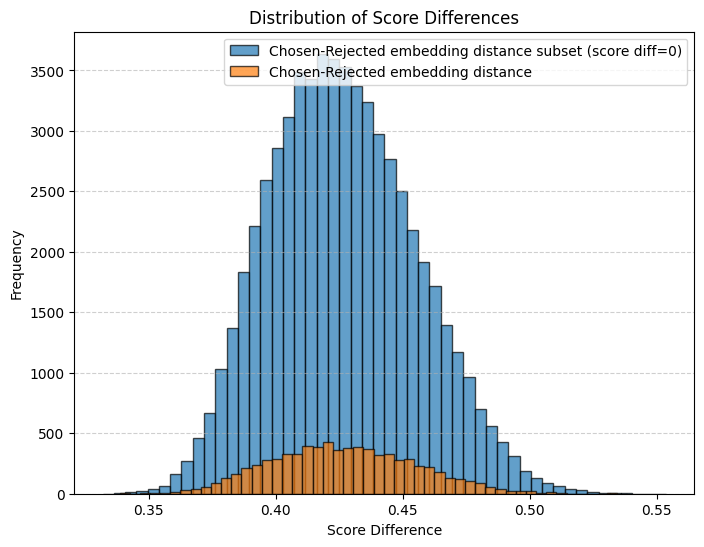

In [47]:
import torch
import matplotlib.pyplot as plt

pair_reward_scores = torch.load("reward_score_results/pair_scores_all.pt")

llama_learning_order_scores = [
    0 if x is None else x for x in sorted_score_subset['llama_learning_order']
]
llama_learning_order_scores_full = [
    0 if x is None else x for x in raw_dataset['llama_learning_order']
]

#### score diff
score_diff = sorted_score_subset['score_diff']
score_diff_full = raw_dataset['score_diff']

reward_score_diff = sorted_score_subset['reward_score_diff']
reward_score_diff_full = raw_dataset['reward_score_diff']


distances = sorted_score_subset['embedding_distance']
distances_full = raw_dataset['embedding_distance']

# 画直方图
plt.figure(figsize=(8, 6))
# plt.hist(score_diff, bins=50, edgecolor='black', alpha=0.7, label="LLM Rating Score Diff Subset")  # bins 控制柱子的数量
# plt.hist(score_diff_full, bins=50, edgecolor='black', alpha=0.7, label="LLM Rating Score Diff")  # bins 控制柱子的数量

# plt.hist(reward_score_diff_full, bins=50, edgecolor='black', alpha=0.7, label='Reward Score Diff')  # bins 控制柱子的数量
# plt.hist(reward_score_diff, bins=50, edgecolor='black', alpha=0.7, label='Reward Score Diff Subset (score diff=0)')  # bins 控制柱子的数量

# plt.hist(rejected_scores, bins=50, edgecolor='black', alpha=0.7, label='Rejected Scores')  # bins 控制柱子的数量
# plt.hist(chosen_scores, bins=50, edgecolor='black', alpha=0.7, label='Chosen Scores')  # bins 控制柱子的数量

### LLama learning order difference
# plt.hist(llama_learning_order_scores_full, bins=50, edgecolor='black', alpha=0.7, label='LLaMA Learning Order')  # bins 控制柱子的数量
# plt.hist(llama_learning_order_scores, bins=50, edgecolor='black', alpha=0.7, label='LLaMA Learning Order Subset (score diff=0)')  # bins 控制柱子的数量

plt.hist(distances_full, bins=50, edgecolor='black', alpha=0.7, label='Chosen-Rejected embedding distance subset (score diff=0)')  # bins 控制柱子的数量
plt.hist(distances, bins=50, edgecolor='black', alpha=0.7, label='Chosen-Rejected embedding distance')  # bins 控制柱子的数量



# 设置标题和轴标签
plt.title("Distribution of Score Differences")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")

# 显示网格
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()

# 显示图像
plt.show()



In [64]:
from scipy.stats import pearsonr

r, p = pearsonr(llama_learning_order_scores_full, score_diff_full)
print(f"Pearson correlation: {r:.4f}, p-value: {p:.4g}")


Pearson correlation: -0.1805, p-value: 0


[[ 1.         -0.22337179]
 [-0.22337179  1.        ]]


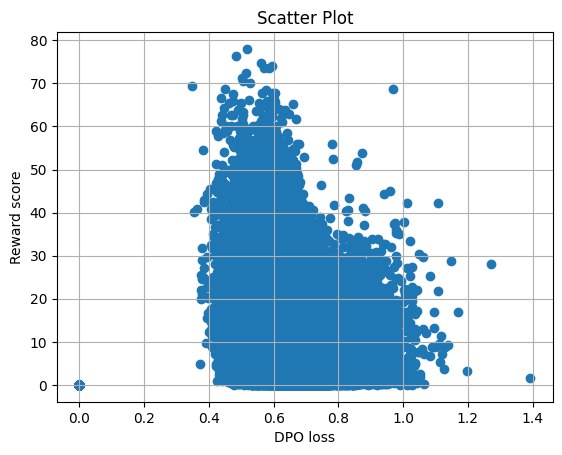

In [62]:
import matplotlib.pyplot as plt
import math
import numpy as np

reward_score_diff_full_new = [abs(score) for score in reward_score_diff_full]




plt.scatter(llama_learning_order_scores_full, reward_score_diff_full_new)
plt.title("Scatter Plot")
plt.xlabel("DPO loss")
plt.ylabel("Reward score")
plt.grid(True)
plt.show()


In [84]:
from datasets import load_dataset, Dataset, DatasetDict


raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
negative_subset = raw_dataset.filter(lambda example: example["reward_score_diff"] < 0 and example["score_chosen"] != example["score_rejected"])


Filter: 100%|██████████| 61135/61135 [00:02<00:00, 30401.35 examples/s]


In [87]:
negative_subset[1]

{'prompt': 'Write a eulogy for a public figure who inspired you.',
 'prompt_id': 'fe97b9785d86a2466561687a0614b68dbc1cd6cd90af057e6dfa56c3fa80fb85',
 'chosen': [{'content': 'Write a eulogy for a public figure who inspired you.',
   'role': 'user'},
  {'content': 'Ladies and gentlemen, family and friends, distinguished guests, we gather here today to celebrate the life and legacy of a great leader, an inspirational figure, and a true patriot – the Honorable John Adams.\n\nJohn Adams was a man who dedicated his life to serving his country and advocating for the rights of his fellow citizens. He was a Founding Father, a statesman, a lawyer, a diplomat, and a voracious learner who never ceased to seek knowledge and wisdom. He believed that through education and hard work, anyone could rise above their circumstances and make a positive impact on the world.\n\nAs a member of the Continental Congress, Adams played a critical role in shaping our nation\'s founding documents, including the Decl

In [73]:
dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['train_prefs']

subset = dataset.filter(lambda example: example["score_chosen"] == example["score_rejected"])


Filter: 100%|██████████| 61135/61135 [00:02<00:00, 28252.80 examples/s]


In [74]:
subset

Dataset({
    features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
    num_rows: 7387
})

## Re-order the chosen and rejected based on reward score

In [13]:
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk


raw_dataset = load_from_disk("datasets/ultrafeedback-random-identical-subset")['train_prefs']


test_dataset = load_from_disk("datasets/ultrafeedback-random-identical-subset")['test_prefs']

pair_reward_scores = torch.load("random_identical_results/pair_scores_all.pt")
reward_score_diff = [ pair_score[0] - pair_score[1] for pair_score in pair_reward_scores]
raw_dataset = raw_dataset.add_column("reward_score_diff", reward_score_diff)


def swap_chosen_rejected(example):
    if example["reward_score_diff"] < 0:
        # 交换 chosen 和 rejected
        example["chosen"], example["rejected"] = example["rejected"], example["chosen"]
        # 同时更新 reward_score_diff 为正值（可选）
        example["reward_score_diff"] = -example["reward_score_diff"]
    return example

# 应用映射函数
raw_dataset = raw_dataset.map(swap_chosen_rejected)


# reward_sorted_dataset = raw_dataset.sort(f"reward_score_diff", reverse=True)

# raw_dataset = raw_dataset.remove_columns([column_name for column_name in raw_dataset.column_names if column_name not in test_dataset.column_names ])

new_reward_score_based_random_identical_dataset = DatasetDict({
    'train_prefs': raw_dataset,
    'test_prefs': test_dataset
})

# new_reward_score_based_random_identical_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward")

new_reward_score_based_random_identical_dataset.save_to_disk("datasets/ultrafeedback-random-identical-reward-score-based-swap-subset")


/tmp/ipykernel_2906037/1404030293.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pair_reward_scores = torch.load("random_identical_results/pair_scores_all.pt")
Saving t

In [12]:
new_reward_score_based_random_identical_dataset

DatasetDict({
    train_prefs: Dataset({
        features: ['source', 'prompt', 'chosen', 'chosen-rating', 'chosen-model', 'rejected', 'rejected-rating', 'rejected-model', 'chosen_docta_score', 'rejected_docta_score', 'reward_score_diff'],
        num_rows: 10000
    })
    test_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected', 'chosen_docta_score', 'rejected_docta_score'],
        num_rows: 2000
    })
})

### Generate SFT dataset

In [3]:
from datasets import load_dataset, load_from_disk, DatasetDict, Dataset

raw_dataset = load_from_disk("datasets/ultrafeedback-random-identical-reverse-subset")['train_prefs']
test_dataset = load_dataset("jlpang888/ultrafeedback_kto_sft")['test']


# sft_kto_random_identical_dataset = Dataset.from_dict({
#     'prompt': raw_dataset['prompt'] *2,
#     'prompt_id': list(range(len(raw_dataset['prompt'] *2))),
#     'messages': raw_dataset['chosen'] + raw_dataset['rejected']
#     })

sft_kto_random_identical_dataset = Dataset.from_dict({
    'prompt': raw_dataset['prompt'],
    'prompt_id': list(range(len(raw_dataset['prompt']))),
    'messages': raw_dataset['chosen'],
    })


new_dataset = DatasetDict({
    'train': sft_kto_random_identical_dataset.shuffle(seed=42),
    'test': test_dataset
})



# new_dataset.save_to_disk("datasets/ultrafeedback-kto-sft-random-identical-subset")
new_dataset.push_to_hub("jlpang888/ultrafeedback-kto-sft-random-identical-subset-chosen-only")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback-kto-sft-random-identical-subset-chosen-only/commit/f61aeab14a5da1399ece722a1bc6473de0fcf26b', commit_message='Upload dataset', commit_description='', oid='f61aeab14a5da1399ece722a1bc6473de0fcf26b', pr_url=None, pr_revision=None, pr_num=None)

In [51]:
sft_kto_random_identical_dataset.to_json("ultrafeedback-kto-sft-random-identical-subset-chosen-only")

DatasetDict({
    train_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'messages'],
        num_rows: 20000
    })
    test_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'messages'],
        num_rows: 1000
    })
})

In [8]:
from datasets import load_dataset, Dataset, DatasetDict
import torch

raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']

test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

# pair_reward_scores = torch.load("reward_score_results/pair_scores_all.pt")
# # reward_score_diff = [ pair_score[0] - pair_score[1] for pair_score in pair_reward_scores]

# reward_score_chosen = [ pair_score[0] for pair_score in pair_reward_scores]
# reward_score_rejected = [ pair_score[1] for pair_score in pair_reward_scores]

# raw_dataset = raw_dataset.add_column("reward_score_diff", reward_score_diff)

# raw_dataset = raw_dataset.add_column("reward_score_chosen", reward_score_chosen)
# raw_dataset = raw_dataset.add_column("reward_score_rejected", reward_score_rejected)
test_dataset = test_dataset.add_column("reward_score_chosen", [1.0 for _ in range(len(test_dataset))])
test_dataset = test_dataset.add_column("reward_score_rejected", [-1.0 for _ in range(len(test_dataset))])


reward_sorted_dataset = raw_dataset.sort(f"reward_score_diff", reverse=True)

reward_sorted_dataset = reward_sorted_dataset.remove_columns([column_name for column_name in reward_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

reward_dataset = DatasetDict({
    'train': reward_sorted_dataset,
    'test': test_dataset
})
reward_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_external_reward/commit/c4a3016d20dd3908961419b6af931b02fd8e998f', commit_message='Upload dataset', commit_description='', oid='c4a3016d20dd3908961419b6af931b02fd8e998f', pr_url=None, pr_revision=None, pr_num=None)

In [2]:
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets


train_dataset = load_dataset("jlpang888/ultrafeedback_sorted_external_reward")['train']
org_test_dataset = load_dataset("jlpang888/ultrafeedback_sorted_external_reward")['test']

def swap_chosen_rejected(example):
    if example["reward_score_diff"] < 0:
        # 交换 chosen 和 rejected
        example["chosen"], example["rejected"] = example["rejected"], example["chosen"]
        # 同时更新 reward_score_diff 为正值（可选）
        example["reward_score_diff"] = -example["reward_score_diff"]
        example["reward_score_chosen"], example["reward_score_rejected"] = example["reward_score_rejected"], example["reward_score_chosen"]
    return example

# 应用映射函数
reward_score_diff = [chosen - rejected for chosen, rejected in zip(train_dataset['reward_score_chosen'], train_dataset['reward_score_rejected'])]


train_dataset = train_dataset.add_column("reward_score_diff", reward_score_diff)

train_dataset = train_dataset.map(swap_chosen_rejected)

train_dataset = train_dataset.sort('reward_score_diff', reverse=True)


# easy_examples_count = int(len(train_dataset) * 0.8 )
# easy_example_subset = train_dataset.select(range(easy_examples_count))
# difficult_example_subset = train_dataset.select(range(easy_examples_count, len(train_dataset))).shuffle(seed=42)

# merged_dataset = concatenate_datasets([difficult_example_subset, easy_example_subset])


# common_cols = set(merged_dataset.column_names) & set(org_test_dataset.column_names)

# merged_dataset = merged_dataset.remove_columns([column_name for column_name in merged_dataset.column_names if column_name not in common_cols ])
# org_test_dataset = org_test_dataset.remove_columns([column_name for column_name in org_test_dataset.column_names if column_name not in common_cols ])


# new_dataset = DatasetDict({
#     'train': merged_dataset,
#     'test': org_test_dataset,
# })


# new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward_swap_warmup")

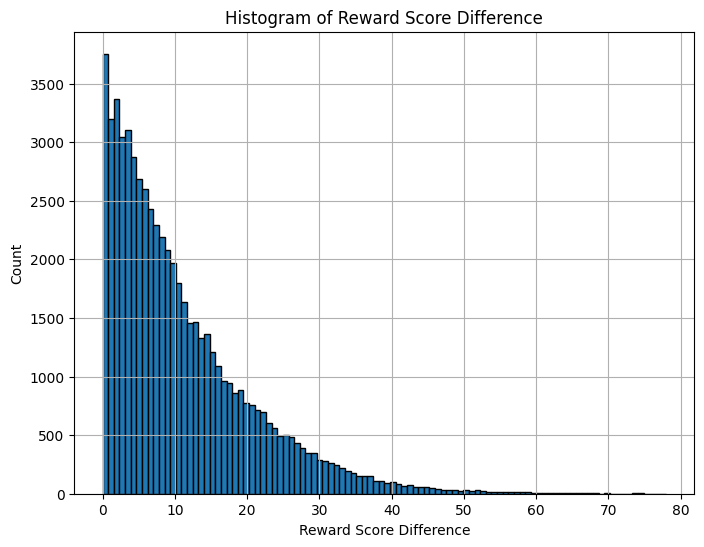

In [9]:
import matplotlib.pyplot as plt

# 假设你的 train_dataset 已经加载好，并且 'reward_score_diff' 是一个 list 或 numpy array
reward_score_diff = train_dataset['reward_score_diff']

# 绘制直方图
plt.figure(figsize=(8, 6))
plt.hist(reward_score_diff, bins=100, edgecolor='black')
plt.xlabel('Reward Score Difference')
plt.ylabel('Count')
plt.title('Histogram of Reward Score Difference')
plt.grid(True)
plt.show()


In [23]:
from datasets import load_dataset

# 先加载原始数据
# dataset = load_dataset("jlpang888/ultrafeedback_sorted_external_reward_swap_warmup")
dataset = load_dataset("jlpang888/ultrafeedback_sorted_external_reward_new")

# 对 train 集进行 shuffle
shuffled_train = dataset["train"].shuffle(seed=42)

# 用新的 train 替换掉原来的
shuffle_dataset = dataset
shuffle_dataset["train"] = shuffled_train

# shuffle_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward_swap_warmup_shuffle")
shuffle_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward_new_shuffle")



Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_external_reward_new_shuffle/commit/a73b0ca052a51697ffb9f3f3671a4f6275a8872e', commit_message='Upload dataset', commit_description='', oid='a73b0ca052a51697ffb9f3f3671a4f6275a8872e', pr_url=None, pr_revision=None, pr_num=None)

In [21]:
shuffle_dataset['train'][0]

{'prompt': 'give me a 500 word summary of what the kodratiev wave is',
 'prompt_id': 'c765a8017cc1e03443762b5f627e131eaf56fdc3db6162e45ac4b204eab30e4c',
 'chosen': [{'content': 'give me a 500 word summary of what the kodratiev wave is',
   'role': 'user'},
  {'content': 'The Kondratiev wave, named after Russian economist Nikolai Kondratiev, is a theory that describes the long-term cycles in economic activity. The theory suggests that economic growth goes through four distinct phases, each lasting approximately 20-25 years. These phases are identified as:\n\n1. A phase of innovation and investment, where new technologies and industries emerge.\n2. A phase of expansion, where growth is driven by increasing production and consumption.\n3. A phase of maturity, where growth slows down as the market becomes saturated.\n4. A phase of stagnation, where economic activity declines and there is a period of recession.\n\nAccording to the theory, each of these phases is characterized by a specific 

In [16]:
dataset["train"][0]

{'prompt': 'Who is the author of https://link.springer.com/article/10.1007/s13347-017-0263-5',
 'prompt_id': '81b936e5e9209c098860208aed9c39d1c0a9d6f7415080addf28bd5197df7310',
 'chosen': [{'content': 'Who is the author of https://link.springer.com/article/10.1007/s13347-017-0263-5',
   'role': 'user'},
  {'content': 'I apologize, I am not able to provide information regarding the author of the article. Can I offer any other assistance?',
   'role': 'assistant'}],
 'rejected': [{'content': 'Who is the author of https://link.springer.com/article/10.1007/s13347-017-0263-5',
   'role': 'user'},
  {'content': "To find the author of the article linked in your question, I'm sorry for the inconvenience, but as an AI, I don't have the ability to access external databases, web pages, or documents. I can't browse the internet in real time, so I can't provide the name of the author of that specific article. However, I can tell you that usually, the author(s) of an article are listed at the beginn

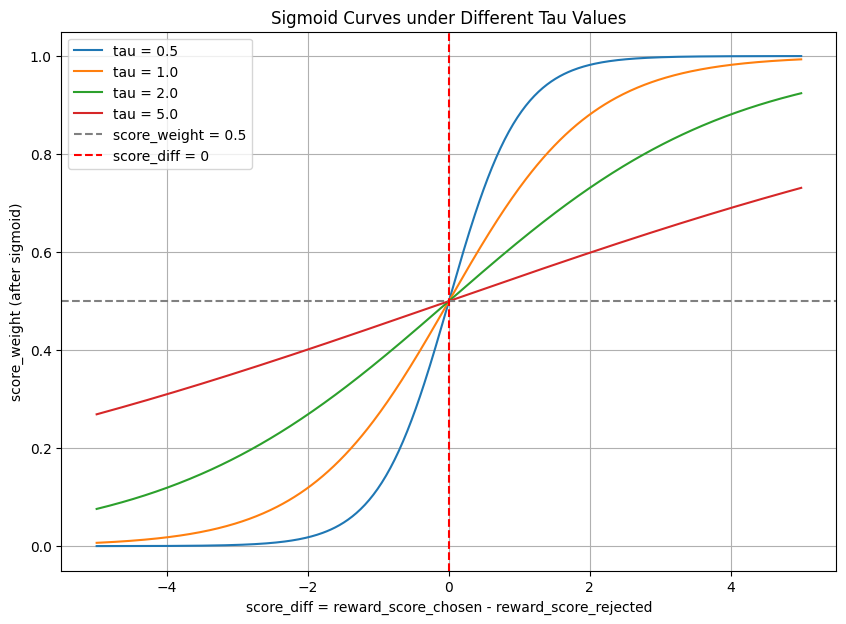

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 生成 score_diff 从 -5 到 5
score_diff = np.linspace(-5, 5, 500)

# 不同的 tau 值
taus = [0.5, 1.0, 2.0, 5.0]

plt.figure(figsize=(10, 7))

# 画不同 tau 下的曲线
for tau in taus:
    score_weight = 1 / (1 + np.exp(-score_diff / tau))  # sigmoid(score_diff / tau)
    plt.plot(score_diff, score_weight, label=f"tau = {tau}")

# 辅助线
plt.axhline(0.5, color='gray', linestyle='--', label='score_weight = 0.5')
plt.axvline(0, color='red', linestyle='--', label='score_diff = 0')

# 标题和标签
plt.xlabel('score_diff = reward_score_chosen - reward_score_rejected')
plt.ylabel('score_weight (after sigmoid)')
plt.title('Sigmoid Curves under Different Tau Values')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from datasets import load_dataset

# 先加载原始数据
# dataset = load_dataset("jlpang888/ultrafeedback_sorted_external_reward_swap_warmup")
dataset = load_dataset("jlpang888/ultrafeedback_sorted_external_reward_new")

# 对 train 集进行 shuffle
shuffled_train = dataset["train"].shuffle(seed=42)

# 用新的 train 替换掉原来的
shuffle_dataset = dataset
shuffle_dataset["train"] = shuffled_train

# shuffle_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward_swap_warmup_shuffle")
shuffle_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward_new_shuffle")



In [12]:
from datasets import load_dataset


# dataset_name = 'jlpang888/ultrafeedback_identical_pairs_7387'
dataset_name= 'HuggingFaceH4/ultrafeedback_binarized'

raw_dataset = load_dataset(dataset_name)


train_dataset = raw_dataset['train']


def force_rejected_to_idk(sample):
    sample['rejected'][-1]['content'] = 'Sorry, I do not know the exact answer.'
    return sample

revised_train_dataset = train_dataset.map(force_rejected_to_idk)


new_dataset = raw_dataset

new_dataset['train'] = revised_train_dataset


new_dataset.push_to_hub("jlpang888/ultrafeedback_identical_pairs_7387_revised")


In [15]:
from datasets import load_dataset


# dataset_name = 'jlpang888/ultrafeedback_identical_pairs_7387'
# dataset_name= 'HuggingFaceH4/ultrafeedback_binarized'

dataset_name= 'jlpang888/ultrafeedback_sorted_score_diff'

raw_dataset = load_dataset(dataset_name)


train_dataset = raw_dataset['train']


def force_rejected_to_idk(sample):
    sample['rejected'][-1]['content'] = 'Sorry, I do not know the exact answer.'
    return sample

revised_train_dataset = train_dataset.map(force_rejected_to_idk)


new_dataset = raw_dataset

new_dataset['train'] = revised_train_dataset.shuffle(seed=42)
# new_dataset['train'] = revised_train_dataset


new_dataset.push_to_hub(f"{dataset_name}_revised_shuffle")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_score_diff_revised_shuffle/commit/423de6721610f0b674310c58fe9e6052cf597a88', commit_message='Upload dataset', commit_description='', oid='423de6721610f0b674310c58fe9e6052cf597a88', pr_url=None, pr_revision=None, pr_num=None)

In [10]:
train_dataset[0]['rejected'][-1]

{'content': 'Sorry, I do not know the exact answer.', 'role': 'assistant'}